# Campaign (Position) Contribution Volumes Notebook

### Load Libraries

In [1]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
from cash_flow_dict import cash_flow_dict

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Load Data

In [2]:
comm_history_cleaned = 'cleaned_data/comm_history_cleaned.csv'
comm_history = pd.read_csv(comm_history_cleaned, low_memory=False)

trans_details_cleaned = 'cleaned_data/trans_details_cleaned.csv'
trans_details = pd.read_csv(trans_details_cleaned, low_memory=False)

transactions_cleaned = 'cleaned_data/transactions_cleaned.csv'
transactions = pd.read_csv(transactions_cleaned, low_memory=False)

In [28]:
list(transactions)

['transaction_id',
 'transaction_date',
 'status',
 'filer_committee',
 'contributor_payee',
 'transaction_subtype',
 'amount',
 'committee_id']

#### Pattern Matching 

In [3]:
def filt(x, patterns):
    for p in patterns.values():
        if re.match(r'^(?i)'+p, x):
            if re.match(r'\D', x):
                return True
            return False
    return False

####  Regex Pattern Template

In [4]:
patterns = {
    'mayor': r'^(?=.*mayor)(?=.*portland).*',
    'comm': r'^(?=.*commissioner)(?=.*(multnomah|portland|labor)).*',
    'auditor': r'^(?=.*auditor).*',
    'treasurer': r'^(?=.*treasurer).*',
    'attorney': r'^(?=.*attorney).*',
    'council': r'^(?=.*(metro|city))(?=.*(councilor|council pres))(?!.*(lake|milwa)).*',
    'chair': r'^(?=.*chair).*',
}

#### Candidate Committees

In [5]:
def candidate_comms(position, region=''):
    # set regex pattern on function argument
    pattern = {position: r'^(?=.*{0})(?=.*({1})).*'.format(position, region)}

    df = comm_history
    df['effective'] = pd.to_datetime(df['effective'], format = '%m/%d/%Y')
    
    # subset committee history by position; extract ids 
    pos_sub = df.loc[
        df.committee_description.apply(lambda x: filt(x, patterns))
        | df.committee_name.apply(lambda x: filt(x, patterns))
    ].copy()
    
    return pos_sub

####  Volume Vizualizer 

In [32]:
def volume_visualizer(position, region=''):
    # set regex pattern on function argument
    patterns = {position: r'^(?=.*{0})(?=.*({1})).*'.format(position, region)}

    df = comm_history
    
    # subset committee history by position; extract ids 
    pos_sub = df.loc[
        df.committee_description.apply(lambda x: filt(x, patterns))
        | df.committee_name.apply(lambda x: filt(x, patterns))
    ].copy()
        
    pos_sub['effective'] = pd.to_datetime(pos_sub['effective'], format='%m/%d/%Y')
    pos_sub['period'] = pos_sub['effective'].dt.to_period('M')
    pos_ids = pos_sub['committee_id'].unique()

    # subset transactions by committee ids; extract transaction ids
    pos_transactions = transactions.loc[transactions['committee_id'].isin(pos_ids)].copy()
    pos_transactions['transaction_date'] = pd.to_datetime(pos_transactions['transaction_date'], format='%m/%d/%Y')
    pos_transactions['period'] = pos_transactions['transaction_date'].dt.to_period('M')
    pos_transactions = pos_transactions[position_transactions['transaction_subtype'].isin(cash_flow_dict['in'])]
    
    # join position subset with position transactions
    join = pos_sub.merge(pos_transactions, how='left', on=['committee_id','period']) 

    # aggregate amount on year
    agg_amount = join[['amount']].groupby(join.transaction_date.dt.year).sum()

    x = agg_amount.index
    y = agg_amount
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.plot(x,y, color = 'blue', linewidth=2)
    ax.plot(y, '--bo')
    ax.set_title('Total Campaign Contributions for ' + position.title(), fontsize=18)
    ax.set(
        ylabel = 'Contributions (Aggregated)',
        xlabel = 'Year'
    )
    return plt.show()

# All Offices' Campaign Volume

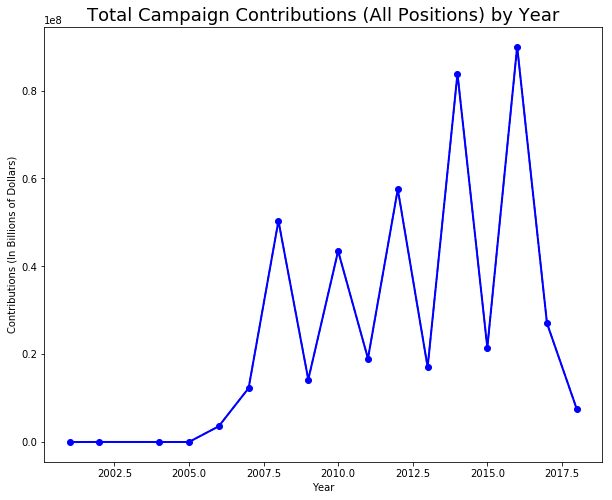

In [48]:
contributions = transactions[transactions['transaction_subtype'].isin(cash_flow_dict['in'])].copy()
contributions['transaction_date'] = pd.to_datetime(contributions['transaction_date'], format='%m/%d/%Y')
agg_amount = contributions['amount'].groupby(contributions['transaction_date'].dt.year).sum()
x = agg_amount.index
y = agg_amount

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(x,y, color = 'blue', linewidth=2)
ax.plot(y, '--bo')
ax.set_title('Total Campaign Contributions (All Positions) by Year', fontsize=18)
ax.set(
    ylabel = 'Contributions (In Billions of Dollars)',
    xlabel = 'Year'
)    
plt.show()

## <font color = 'red'> Statewide Offices

### Govenor

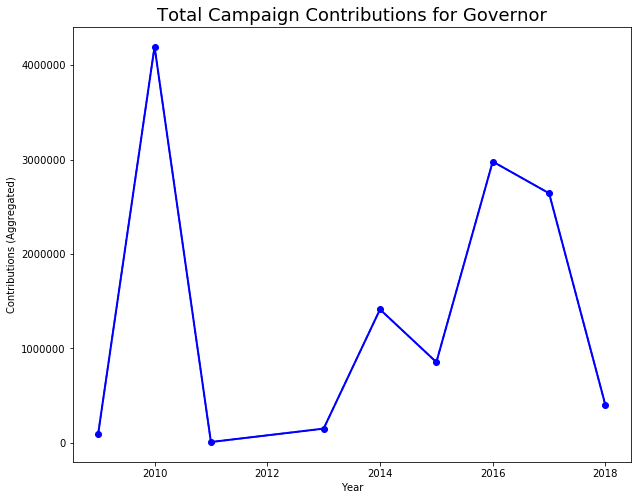

In [7]:
volume_visualizer('governor')

### Secretary of State

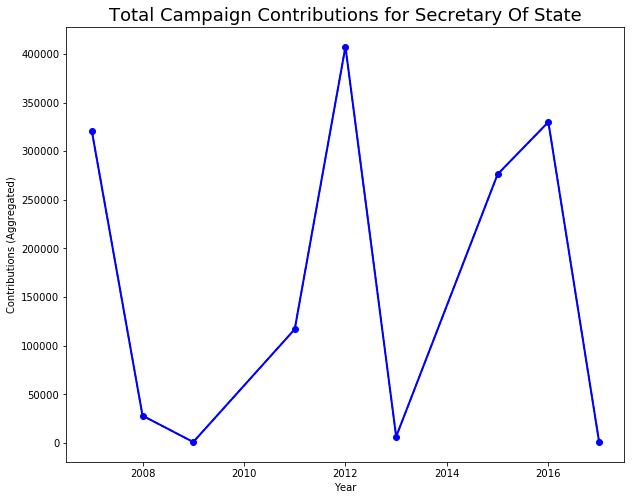

In [8]:
volume_visualizer('secretary of state')

### State Treasurer 

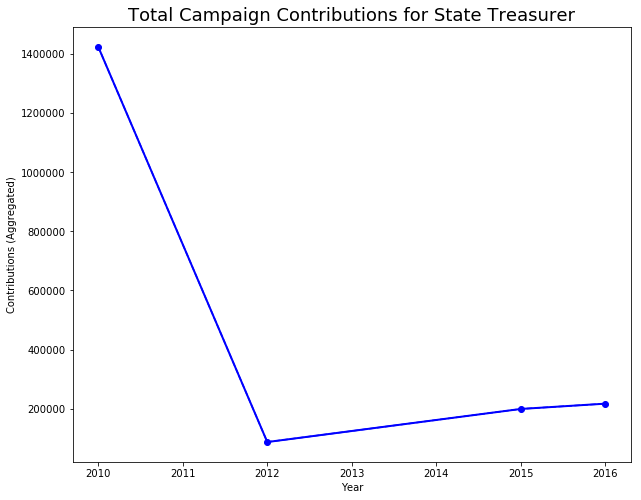

In [9]:
volume_visualizer('state treasurer')

### Labor Commissioner

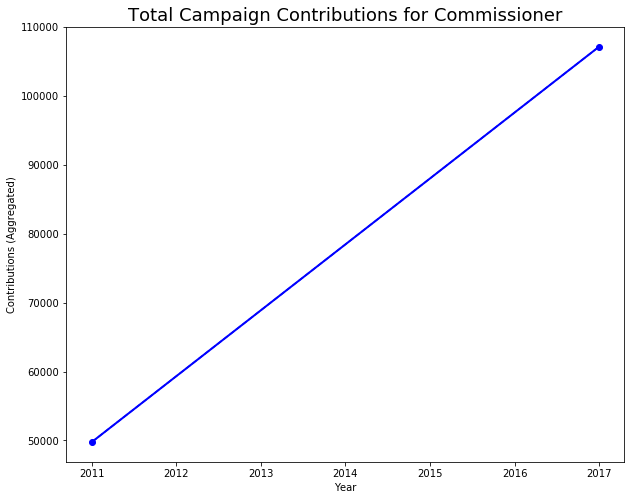

In [10]:
volume_visualizer('commissioner','labor')

### Attorney General

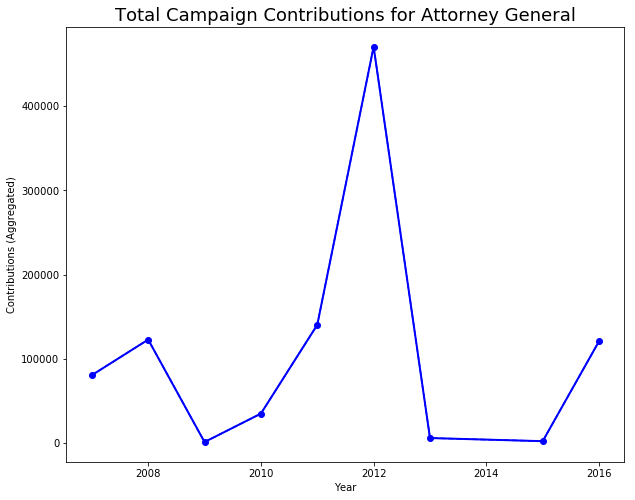

In [11]:
volume_visualizer('attorney general')

## <font color = 'blue'> State Legislature

### State Senate

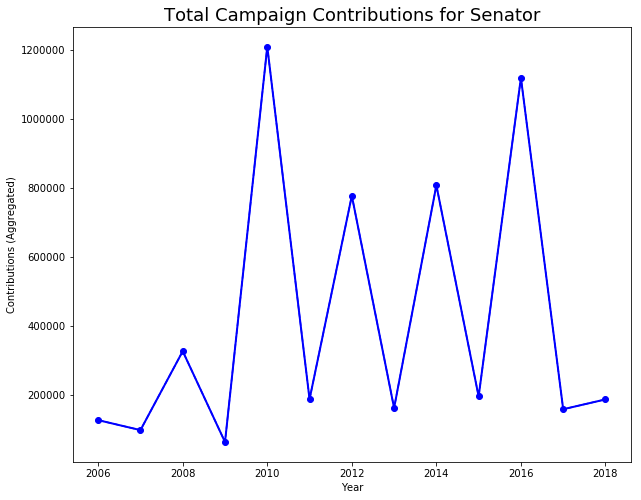

In [12]:
volume_visualizer('senator')

### State Congressional

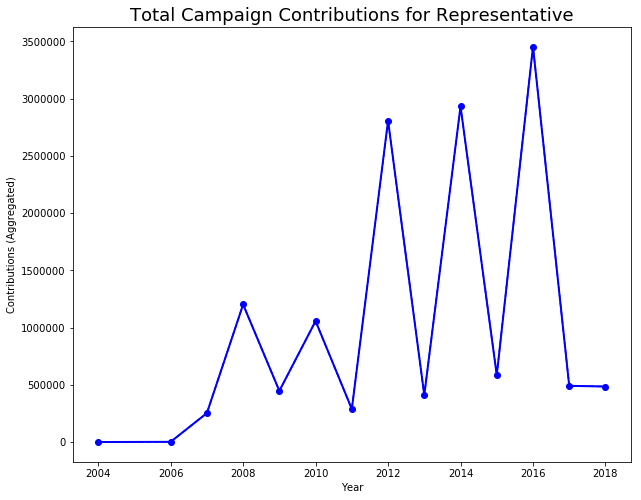

In [13]:
volume_visualizer('representative')

## <font color = 'green'> Local

### Mayor of Portland

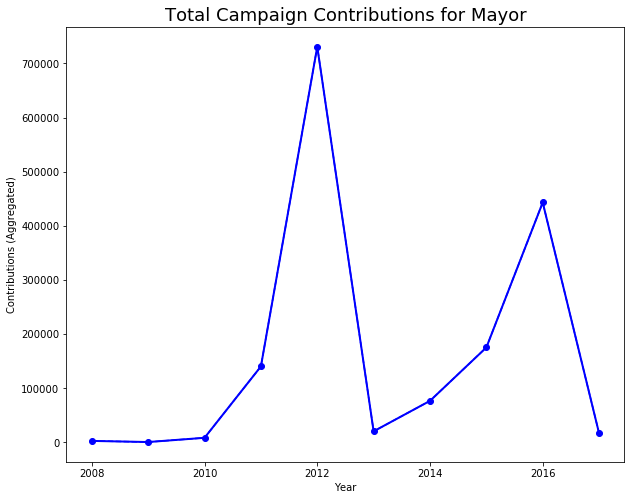

In [14]:
volume_visualizer('mayor')

### Portland Commissioners

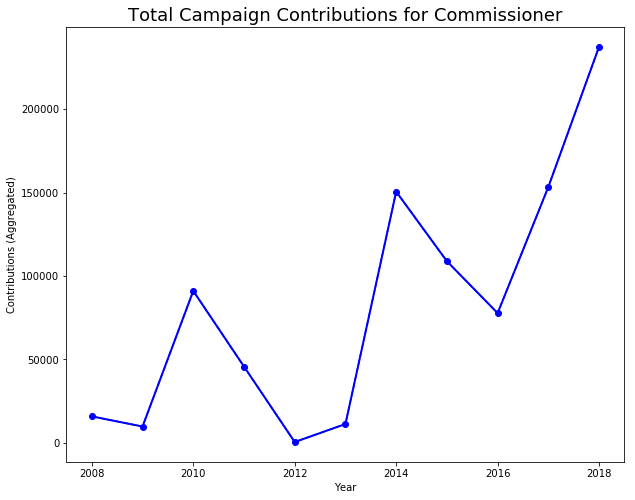

In [15]:
volume_visualizer('commissioner','portland')

### Multnomah County Chair

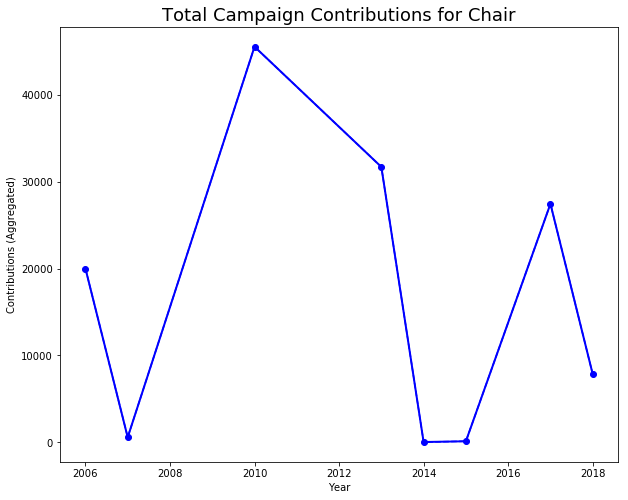

In [16]:
volume_visualizer('chair','multnomah')

### Multnomah County Commissioner

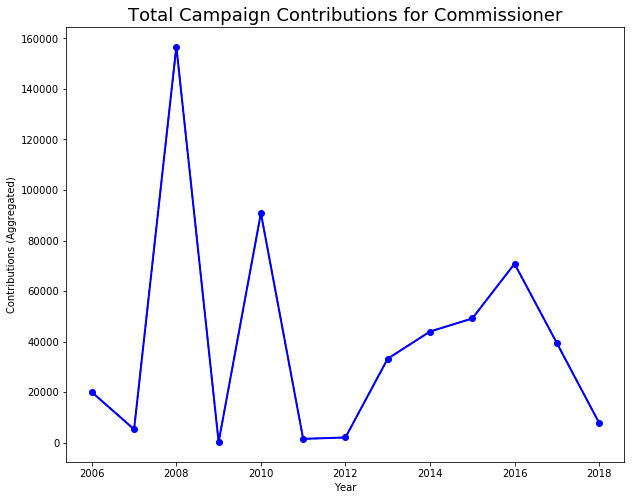

In [17]:
volume_visualizer('commissioner','multnomah')

### Metro Pres

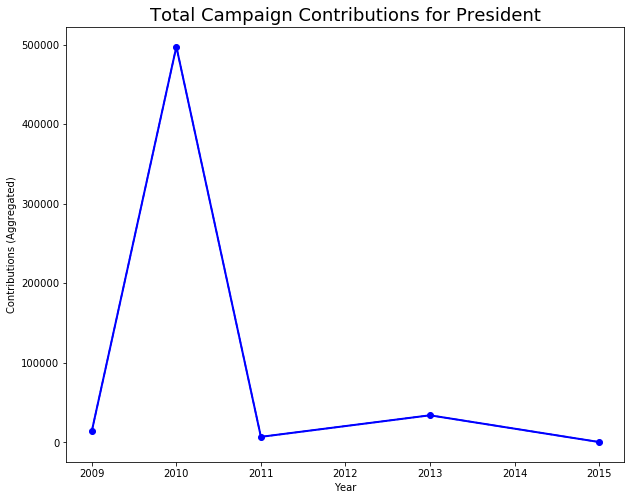

In [18]:
volume_visualizer('president','metro')

### Metro Councilor

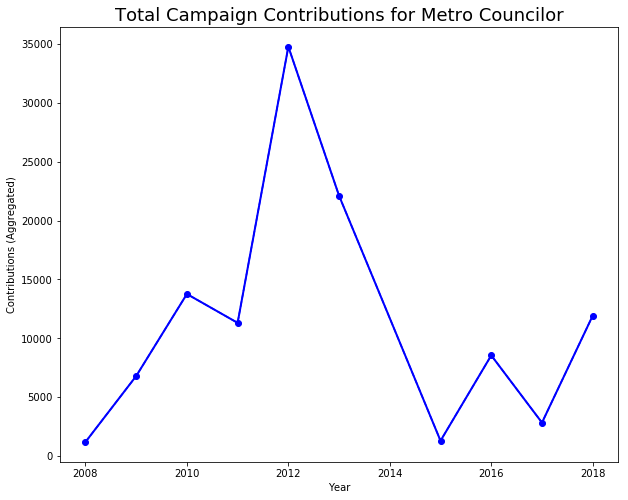

In [19]:
volume_visualizer('metro councilor')